In [28]:
from zipline.api import order_target_percent, record, symbol, schedule_function, date_rules, order
from zipline.api import set_commission, commission, set_slippage, slippage
from zipline import run_algorithm
from zipline.utils.events import time_rules

import pandas as pd
import numpy as np

import requests
from datetime import datetime
from zipline.api import set_commission, set_slippage
from zipline.finance.commission import PerShare, PerDollar
from zipline.finance.slippage import VolumeShareSlippage

In [29]:
RETS_FILE_PATH = 'historical_returns.csv'

In [30]:
def get_weights_for_date(date):
  
    # The base URL of your Flask application
    base_url = "http://localhost:5000/get_weights"
    
    # Prepare the query parameters
    params = {'date': str(date)}
    
    try:
        # Sending a GET request to the endpoint
        response = requests.get(base_url, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Parse the JSON response
            data = response.json()
            return data.get('weights')
        else:
            # Handle possible errors (e.g., invalid date format, missing date parameter)
            print(f"Error: {response.json()['error']}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [31]:
# Define the initialize function
def initialize(context):

        # Set the commission model
    #set_commission(PerDollar(cost=0.0001))
    set_commission(PerDollar(cost=0))
    
    # Set the slippage model
    # VolumeShareSlippage takes 'volume_limit' and 'price_impact' as parameters
    # 'volume_limit' is the fraction of a bar's volume that your order can take up
    # 'price_impact' is the impact your order has on the price per share for each share traded
    #set_slippage(VolumeShareSlippage(volume_limit=0.025, price_impact=0.01))
    
    # Slippage model: Assuming 0.05% slippage per trade
    #set_slippage(slippage.VolumeShareSlippage(volume_limit=0.025, price_impact=0.0005))

    
    context.tickers = ['VWO', 'SPY', 'VNQ', 'LQD', 'DBC']
    context.assets = [symbol(ticker) for ticker in context.tickers]
    
    # Schedule the rebalance function to run every Monday at market open
    schedule_function(rebalance, date_rules.week_start(), time_rules.market_open())
    # Set the context attributes needed
    context.lookback_days = 50 # look back over 50 days for the moving average

# Define the rebalance function
def rebalance(context, data):
    #print(context.get_datetime().date())
     
    # Get historical data for the assets
    historical_data = data.history(context.assets, "price", context.lookback_days + 1, "1d")
    
#     # Calculate daily returns
    daily_returns = historical_data.pct_change().dropna()
    daily_returns.to_csv(RETS_FILE_PATH)
    current_date = context.get_datetime().date()
    
    print(f'Handling {current_date}')
    
    weights = get_weights_for_date(current_date)
    
    # Place orders
    for asset, weight in zip(context.assets, weights):
        if data.can_trade(asset):
            order_target_percent(asset, weight)
            #print(f'ordered {asset}: {weight}')
    
    # Record some metrics
    record(weights=weights)

# Define the analyze function (optional)
def analyze(context, perf):
    # Plot portfolio weights over time
    #perf.weights.plot()
    pass

In [ ]:
start_date = pd.Timestamp('2017-12-15', tz='UTC')#pd.Timestamp('2020-12-15', tz='UTC')
end_date = pd.Timestamp('2020-12-15', tz='UTC')#pd.Timestamp('2023-12-15', tz='UTC') # 2023

# start_date = pd.Timestamp('2020-12-15', tz='UTC')
# end_date = pd.Timestamp('2023-12-15', tz='UTC') # 2023

capital_base = 1e7

perf = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    analyze=analyze,
    capital_base=capital_base,
    data_frequency='daily',
    bundle='thesis1' 
)

Handling 2017-12-18


C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\empyrical\stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Handling 2017-12-26
Handling 2018-01-02
Handling 2018-01-08
Handling 2018-01-16
Handling 2018-01-22
Handling 2018-01-29
Handling 2018-02-05
Handling 2018-02-12
Handling 2018-02-20
Handling 2018-02-26
Handling 2018-03-05
Handling 2018-03-12
Handling 2018-03-19
Handling 2018-03-26
Handling 2018-04-02
Handling 2018-04-09
Handling 2018-04-16
Handling 2018-04-23
Handling 2018-04-30
Handling 2018-05-07
Handling 2018-05-14
Handling 2018-05-21
Handling 2018-05-29
Handling 2018-06-04
Handling 2018-06-11
Handling 2018-06-18
Handling 2018-06-25
Handling 2018-07-02
Handling 2018-07-09
Handling 2018-07-16
Handling 2018-07-23
Handling 2018-07-30
Handling 2018-08-06
Handling 2018-08-13
Handling 2018-08-20
Handling 2018-08-27
Handling 2018-09-04
Handling 2018-09-10
Handling 2018-09-17
Handling 2018-09-24
Handling 2018-10-01
Handling 2018-10-08
Handling 2018-10-15
Handling 2018-10-22


In [8]:
tmp_perf = perf.copy()

## Save the result

In [9]:
perf = tmp_perf.copy()

In [13]:
non_zero_mask = perf['returns'] != 0

# Generate random variables with mean 0.01 for non-zero elements
random_variables = np.random.normal(loc=0.000005, scale=0.0001, size=len(perf))

In [15]:
# Add random variables to non-zero elements
perf.loc[non_zero_mask, 'returns'] += random_variables[non_zero_mask]


In [21]:
PERF_NAME = '1overN_1_year'
perf.to_csv(fr'..\analytics\perfs\{PERF_NAME}_perf.csv')

# Analytics

In [12]:
# mean_returns: -0.00010125631146584078
# std: 0.00865933273125334
# Cumulative Returns: -0.09905234115396078
# Annualized Returns: -0.03408325329298956
# Sharpe Ratio: -0.1848903807067875
# Max Drawdown: -0.31124368401512414


# Without commisions

# mean_returns: -8.009327644662554e-05
# std: 0.008657064940810248
# Cumulative Returns: -0.08458377480699852
# Annualized Returns: -0.02895365337523903
# Sharpe Ratio: -0.14628578076552828
# Max Drawdown: -0.3069968239820765

In [46]:
import empyrical as ep

# Assuming 'perf' is your DataFrame and it has a 'returns' column

# Cumulative returns
cumulative_returns = ep.cum_returns_final(perf['returns'])

# Annualized returns
annualized_returns = ep.annual_return(perf['returns'])

# Sharpe ratio
sharpe_ratio = ep.sharpe_ratio(perf['returns'])

# Max drawdown
max_drawdown = ep.max_drawdown(perf['returns'])

print(f"mean_returns: {perf[perf['returns'] != 0]['returns'].mean()}")
print(f"std: {perf[perf['returns'] != 0]['returns'].std()}")

print(f"Cumulative Returns: {cumulative_returns}")
print(f"Annualized Returns: {annualized_returns}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")


mean_returns: 0.0001294441576526693
std: 0.010196345905772015
Cumulative Returns: 0.05949500609900049
Annualized Returns: 0.019476891042317757
Sharpe Ratio: 0.20126249314578104
Max Drawdown: -0.2946789117243629


In [7]:
tmp = [perf['weights'][i][1] for i in range(4, len(perf['weights']))]
tmp = np.array(tmp)
tmp[tmp > 1]

array([], dtype=float64)

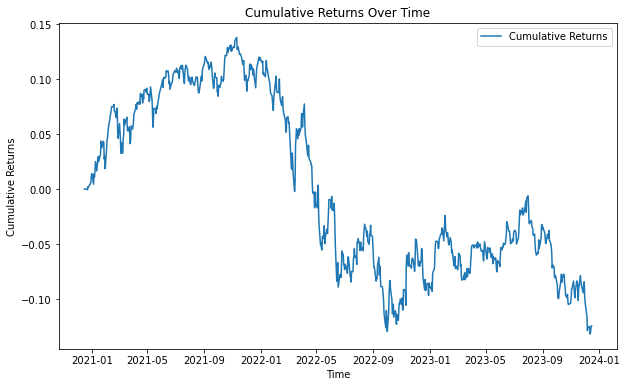

In [8]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

perf['cumulative_returns'] = (1 + perf['returns']).cumprod() - 1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(perf['cumulative_returns'], label='Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [29]:
perf['weights']

2020-12-15 21:00:00+00:00                                                  NaN
2020-12-16 21:00:00+00:00                                                  NaN
2020-12-17 21:00:00+00:00                                                  NaN
2020-12-18 21:00:00+00:00                                                  NaN
2020-12-21 21:00:00+00:00    [-0.03311106562614441, 0.48139920830726624, -0...
                                                   ...                        
2023-12-11 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-12 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-13 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-14 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-15 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
Name: weights, Length: 758, dtype: object

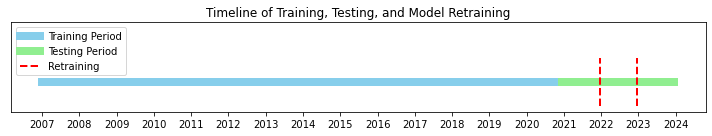

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Define the dates
start_date = datetime(2007, 1, 3)
retraining_dates = [datetime(2021, 12, 15), datetime(2022, 12, 15)]
test_start_date = datetime(2020, 12, 15)
end_date = datetime(2023, 12, 15)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Highlight the training period
ax.plot([start_date, test_start_date], [1, 1], color="skyblue", linewidth=8, label='Training Period')

# Highlight the testing period
ax.plot([test_start_date, end_date], [1, 1], color="lightgreen", linewidth=8, label='Testing Period')

# Mark the retraining dates
for date in retraining_dates:
    plt.plot([date, date], [0.8, 1.2], color="red", linestyle='--', linewidth=2)

# Adding annotations for retraining dates
for date in retraining_dates:
    ax.text(date, 1.25, '', ha='center', color='red')

# Adjust the plot
ax.set_ylim(0.75, 1.5)
ax.yaxis.set_visible(False)  # Hide the y-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Adding labels and title
plt.title('Timeline of Training, Testing, and Model Retraining')

# Adding custom legend
handles, labels = ax.get_legend_handles_labels()
custom_lines = [plt.Line2D([0], [0], color="skyblue", lw=8),
                plt.Line2D([0], [0], color="lightgreen", lw=8),
                plt.Line2D([0], [0], color="red", linestyle='--', lw=2)]
plt.legend(custom_lines, ['Training Period', 'Testing Period', 'Retraining'])

plt.tight_layout()
plt.show()
